# Homework 2

In [1]:
import rpy2
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(1337)
%load_ext rpy2.ipython

In [2]:
%%R -o d
# Make sure we have correct R library path
.libPaths("C:/Users/ville_000/Documents/R/win-library/3.6")
library(rstan)
library(rethinking)
data(Howell1)
d = Howell1

D:\condaenvs\dev\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


## Stuff from lecture

### Data pre-processing

In [3]:
from sklearn.preprocessing import StandardScaler

scaler_lvl = StandardScaler()
scaler_lvl.fit(d[['weight']].values)
d['weight_s'] = scaler_lvl.transform(d[['weight']].values)
d['weight_s2'] = np.power(d['weight_s'], 2)

scaler_loglvl = StandardScaler()
d['weight_ln'] = np.log(d['weight'])
scaler_loglvl.fit(d[['weight_ln']].values)
d['weight_ln_s'] = scaler_loglvl.transform(d[['weight_ln']].values)
d['weight_ln_s2'] = np.power(d['weight_ln_s'], 2)

# Frame with only adults in it
d_adults = d[d["age"] >= 18]

### Exploring data

In [4]:
d.head()

,height,weight,age,male,weight_s,weight_s2,weight_ln,weight_ln_s,weight_ln_s2
0,151.76,47.83,63.00,1,0.83,0.69,3.87,0.74,0.55
1,139.70,36.49,63.00,0,0.06,0.00,3.60,0.27,0.07
2,136.53,31.86,65.00,0,-0.25,0.06,3.46,0.03,0.00
3,156.84,53.04,41.00,1,1.19,1.41,3.97,0.92,0.84
4,145.41,41.28,51.00,0,0.39,0.15,3.72,0.48,0.23


In [5]:
d.describe()

,height,weight,age,male,weight_s,weight_s2,weight_ln,weight_ln_s,weight_ln_s2
count,544.00,544.00,544.00,544.00,544.00,544.00,544.00,544.00,544.00
mean,138.26,35.61,29.34,0.47,-0.00,1.00,3.44,-0.00,1.00
std,27.60,14.72,20.75,0.50,1.00,1.03,0.58,1.00,1.59
min,53.98,4.25,0.00,0.00,-2.13,0.00,1.45,-3.47,0.00
25%,125.09,22.01,12.00,0.00,-0.93,0.19,3.09,-0.61,0.22
50%,148.59,40.06,27.00,0.00,0.30,0.66,3.69,0.43,0.49
75%,157.48,47.21,43.00,1.00,0.79,1.51,3.85,0.72,0.93
max,179.07,62.99,88.00,1.00,1.86,4.55,4.14,1.22,12.02


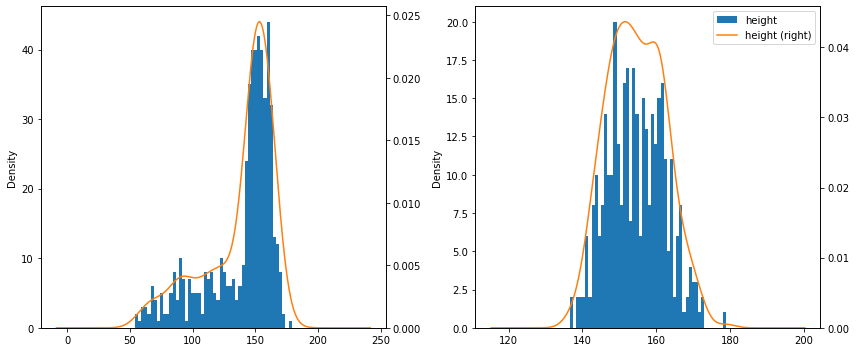

In [6]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
_ = d["height"].plot.hist(ax=ax, bins=50)
_ = d["height"].plot.kde(ax=ax, secondary_y=True)
ax.right_ax.set_ylim(0, ax.right_ax.get_ylim()[1])
ax = fig.add_subplot(122)
_ = d.loc[d["age"]>=18,["height"]].plot.hist(ax=ax, bins=50)
_ = d.loc[d["age"]>=18,["height"]].plot.kde(ax=ax, secondary_y=True)
ax.right_ax.set_ylim(0, ax.right_ax.get_ylim()[1])
plt.tight_layout()

### Model for height (*model_1*)

Gaussian model for height

\begin{align}
 h_i \sim N(\mu, \sigma)
\end{align}

Parametes $\mu$ and $\sigma$ need to be inferred from the data. In Bayesian inference, we first give some prior distributions to them.

\begin{align}
 \mu \sim N(178, 20) \\
 \sigma \sim \text{Uniform}(0, 50)
\end{align}

- Draw samples of mean heights from normal distribution. Prior mean height 178 here is arbitrary, and probably not a good one as it is higher than average Kalahari forager height.
- Draw sample of stds from uniform distribution.

Once the parameters have prior distributions, we can sample heights given the prior distributions. This is called sampling from *prior predictive distribution*: **before seeing the data, what does the model believe?**


#### Prior distributions

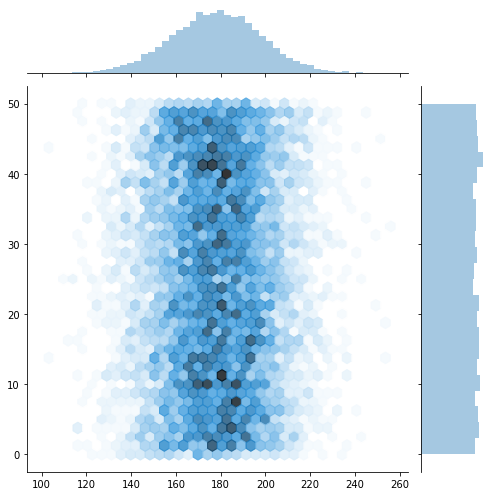

In [7]:
sample_mu = np.random.normal(loc=178, scale=20, size=10000)
sample_sigma = np.random.uniform(low=0, high=50, size=10000)
_ = sns.jointplot(sample_mu,sample_sigma, alpha = 0.8, kind = 'hex', height=7)

#### Sample from predictive prior distribution

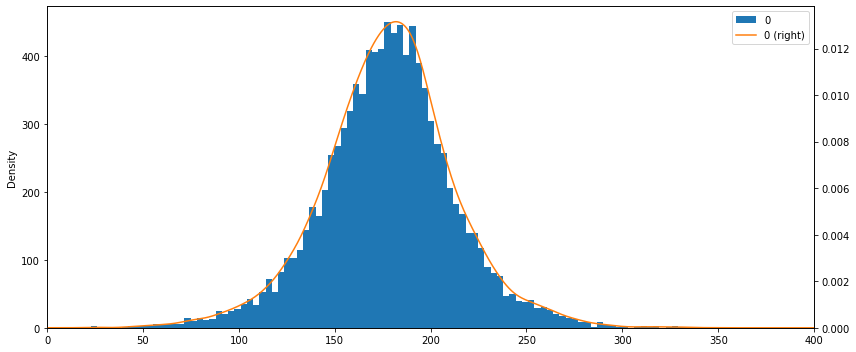

In [8]:
# Sample
prior_h = pd.DataFrame(np.random.normal(loc=sample_mu, scale=sample_sigma))
# Plot predictive prior distribution
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
_ = prior_h.plot.hist(ax=ax, bins=100)
_ = prior_h.plot.kde(ax=ax, secondary_y=True)
_ = ax.set_xlim(0,400)
ax.right_ax.set_ylim(0, ax.right_ax.get_ylim()[1])
plt.tight_layout()

#### Get posterior using grid approximation
Skip!

#### Get posterior distribution using quadratic approximation (Gaussian)

In the end, we are interested about the posterior distribution. There are essentially three ways ot calculate it. One is *quadratig approximation*: it approximates posterior as (multi-dimensional) Gaussian distribution.

Function *quap* in the rethinking package. 

In [9]:
%%R -i d_adults -o summary,sample_posterior

# Define model
flist = alist(
    height ~ dnorm(mu, sigma),
    mu ~ dnorm(178, 20),
    sigma ~ dunif(0, 50)
)

# Build model for calculating draws from posterior.
# Fit model contains as outcome list of parameter means and convariance matrices
# (between parameters), which is enough to describe (multi-dimensional) normal distribution
model_1 = quap(flist, data=d_adults)

# Summary of analytical outcome
# Mean and std of marginal distribution of each parameter
summary = precis(model_1)

# Draw samples of paramets from the (Gaussian approximated) posterior
# mus and sigmas
sample_posterior = extract.samples(model_1, n=10000)

D:\condaenvs\dev\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [10]:
# Print analytical results
print(summary)

        mean   sd   5.5%  94.5%

mu    154.61 0.41 153.95 155.27

sigma   7.73 0.29   7.27   8.20



,mu,sigma
count,10000.00,10000.00
mean,154.60,7.73
std,0.41,0.29
min,153.26,6.58
5.5%,153.95,7.26
50%,154.60,7.73
94.5%,155.26,8.19
max,156.11,8.82


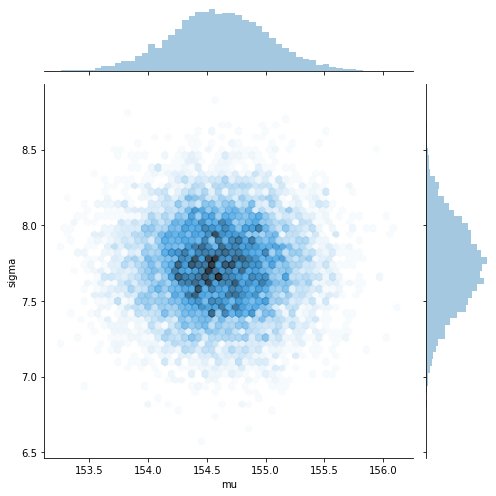

In [11]:
# Print result from drawn sample
display(sample_posterior.describe(percentiles=[0.055, 0.945]))
_ = sns.jointplot(sample_posterior['mu'],sample_posterior['sigma'], alpha = 0.8, kind = 'hex', height=7)

### Model for height with weight as predictor (*m2*)

\begin{align}
 h_i \sim N(\mu, \sigma) \qquad & \text{likelihood} \\
 \mu_i = \alpha + \beta (x_i - \bar{x}) \qquad & \text{linear model}  \\
 \alpha \sim N(178, 20) \qquad & \text{prior}  \\
 \sigma \sim \text{Uniform}(0, 50) \qquad & \text{prior}  \\
 \beta \sim N(0, 10) \qquad & \text{prior} 
\end{align}

Notice we are centering the predictor, so that $\alpha$ will denote the population mean.

In [12]:
# Hundred draws out pf prior predictive distribution
N = 100
# Sample mean weight
xbar = d_adults["weight"].mean()

# Define grid over which we evaluate (prior) predictive distribution
min_p = d_adults["weight"].min()
max_p = d_adults["weight"].max()
x_grid = np.arange(min_p, max_p, 0.2)

#### Prior predictive distribution for $\mu$
We notice that the prior predictive distribution for $\mu$ allows fro quite unrealistic cases.

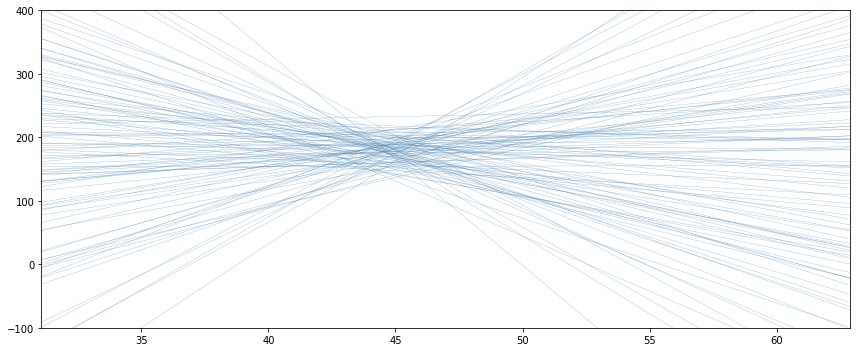

In [13]:
# Draw values for alpha and beta
alpha = np.random.normal(loc=178, scale=20, size=N)
beta = np.random.normal(loc=0, scale=10, size=N)

# Calculate mu
mu = np.empty((len(x_grid),N))
for i,(a,b) in enumerate(zip(alpha, beta)):
    mu[:,i] = a + b * (x_grid-xbar)
mu = pd.DataFrame(mu)
mu.index = x_grid

# Plot prior predictive distribution for mu
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
_ = mu.plot(ax=ax, legend=False, color="steelblue", linewidth=0.2)
_ = ax.set_ylim(-100,400)
plt.tight_layout()

Let's make the prior for $\beta$ better: log-normal. This yields more plausible prior predictive distribution for $\mu$.

\begin{align}
 \beta \sim \text{Log-Normal}(0, 1) \qquad & \text{prior} 
\end{align}

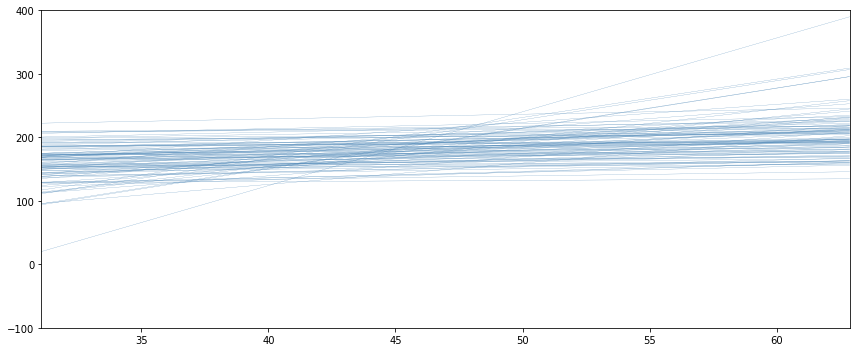

In [14]:
# Re-draw prior values for beta
beta = np.random.lognormal(mean=0, sigma=1, size=N)

# Calculate mu
mu = np.empty((len(x_grid),N))
for i,(a,b) in enumerate(zip(alpha, beta)):
    mu[:,i] = a + b * (x_grid-xbar)
mu = pd.DataFrame(mu)
mu.index = x_grid

# Plot prior predictive distribution for mu
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
_ = mu.plot(ax=ax, legend=False, color="steelblue", linewidth=0.2)
_ = ax.set_ylim(-100,400)
plt.tight_layout()

#### Build model using quadratig approximation

In [15]:
%%R -i d_adults,xbar -o summary_m2,sample_posterior_m2

# Define model
flist = alist(
    height ~ dnorm(mu, sigma),
    mu <- a + b * (weight - xbar),
    a ~ dnorm(178, 20),
    b ~ dlnorm(0,1),
    sigma ~ dunif(0, 50)
)

# Build model for calculating draws from posterior
m2 = quap(flist, data=d_adults)

# Summary of analytical outcome
# Mean and std of marginal distribution of each parameter
summary_m2 = precis(m2)

# Draw samples of parameters from the (Gaussian approximated) posterior
# mus and sigmas
sample_posterior_m2 = extract.samples(m2, n=10000)

In [16]:
print(summary_m2)

        mean   sd   5.5%  94.5%

a     154.60 0.27 154.17 155.03

b       0.90 0.04   0.84   0.97

sigma   5.07 0.19   4.77   5.38



#### Predictive posterior distribution for $\mu$
This is plot weight - average height. In *rethinking* package, function *link* does the same stuff as what is done here below.

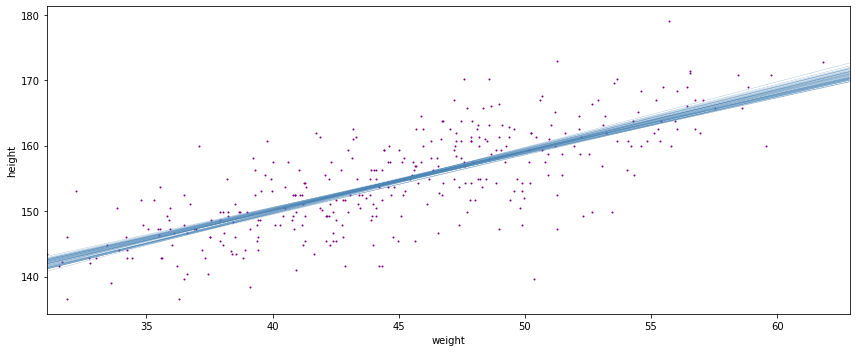

In [17]:
nolines = 50

# Draw values for alpha and beta
alpha = sample_posterior_m2['a'][:nolines]
beta = sample_posterior_m2['b'][:nolines]

# Calculate mu
mu = np.empty((len(x_grid),len(sample_posterior_m2[:nolines])))
for i,(a,b) in enumerate(zip(alpha, beta)):
    mu[:,i] = a + b * (x_grid-xbar)
mu = pd.DataFrame(mu)
mu.index = x_grid

# Plot prior predictive distribution for mu
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
_ = mu.plot(ax=ax, legend=False, color="steelblue", linewidth=0.2)
_ = d_adults[['weight','height']].plot(ax=ax, kind='scatter', x='weight', y='height', s=1, c='purple')
plt.tight_layout()

### 2nd-order polynomial model (*m3*)

\begin{align}
 h_i \sim N(\mu, \sigma) \qquad & \text{likelihood} \\
 \mu_i = \alpha + \beta_1 x_i + \beta_2 x_{i}^{2} \qquad & \text{linear model}  \\
 \alpha \sim N(178, 20) \qquad & \text{prior}  \\
 \beta_1 \sim \text{Log-Normal}(0, 1) \qquad & \text{prior} \\
 \beta_2 \sim N(0, 1) \qquad & \text{prior}  \\
 \sigma \sim \text{Uniform}(0, 50) \qquad & \text{prior} 
\end{align}

We are using full !Kung dataset (chlidren and adults). Here $x_i$ are z-score standardized.

Quadratic model is not perfect; *polynominal grief*. 2md-prder polynomial it has to turn downwards at some point. This is not present in data: with weight height gets bigger.

In [18]:
%%R -i d,xbar -o summary_m3,sample_posterior_m3,x_grid,mu_mean,mu_PI,height_PI

# Define model
flist = alist(
    height ~ dnorm(mu, sigma),
    mu <- a + b1 * weight_s + b2 * weight_s2,
    a ~ dnorm(178, 20),
    b1 ~ dlnorm(0,1),
    b2 ~ dnorm(0,1),    
    sigma ~ dunif(0, 50)
)

# Build model for calculating draws from posterior
m3 = quap(flist, data=d)

# Summary of analytical outcome
# Mean and std of marginal distribution of each parameter
summary_m3 = precis(m3)

# Draw samples of parameters from the (Gaussian approximated) posterior
# mus and sigmas
sample_posterior_m3 = extract.samples(m3, n=10000)

# Calculate mu posterior draws using function link
x_grid = seq(from=-2.2, to=2, length.out=30)
exo_grid = list(weight_s=x_grid, weight_s2=x_grid^2)

# Posterior distribution for mu
mu = link(m3, data=exo_grid)

# Mean mu
mu_mean = apply(mu, 2, mean)

# To simulate observations that average over posterior distributions, use sim
sim_height = sim(m3, data=exo_grid)

# Probability intervals for mu and simualted heights
mu_PI = apply(mu, 2, PI, prob=0.89)
height_PI = apply(sim_height, 2, PI, prob=0.89)

# Output R objects in better format
mu_PI = as.data.frame(t(mu_PI))
height_PI = as.data.frame(t(height_PI))
x_grid = as.data.frame(x_grid)

        mean   sd   5.5%  94.5%

a     146.06 0.37 145.47 146.65

b1     21.71 0.29  21.25  22.17

b2     -7.79 0.27  -8.23  -7.35

sigma   5.77 0.18   5.49   6.06



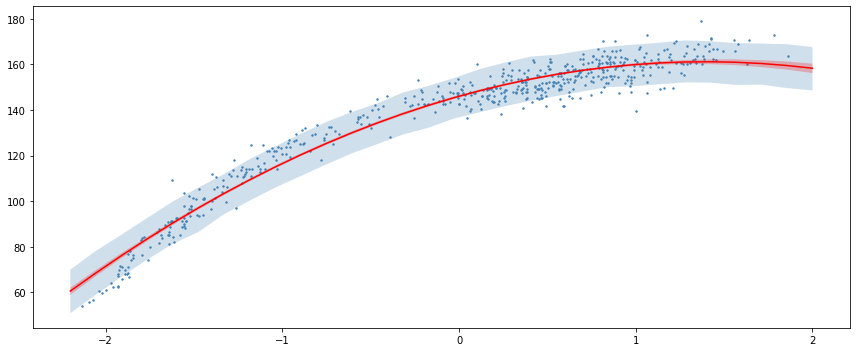

In [19]:
# Summary
print(summary_m3)

# Plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
x = x_grid['x_grid']
_ = ax.scatter(x="weight_s", y="height", c="steelblue", s=2, data=d)
_ = ax.fill_between(x, height_PI.iloc[:,0], height_PI.iloc[:,1], facecolor='steelblue', alpha=0.25)
_ = ax.plot(x, mu_mean, c='red')
_ = ax.fill_between(x, mu_PI.iloc[:,0], mu_PI.iloc[:,1], facecolor='red', alpha=0.25)
plt.tight_layout()

## Question 1
*The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.*

To answer this, we'll use the sampled values from **model_2** above for $\alpha$, $\beta$.

In [20]:
weights = np.array([45, 40, 65, 31, 53])
alpha = sample_posterior_m2['a']
beta = sample_posterior_m2['b']
mu = np.empty((len(weights),len(sample_posterior_m2)))
for i,(a,b) in enumerate(zip(alpha, beta)):
    mu[:,i] = a + b * (weights-xbar)
mu = pd.DataFrame(mu)
mu.index = weights
mu = mu.T

result = mu.describe(percentiles=[0.055, 0.945])
result[result.index.isin(["mean","5.5%","94.5%"])]

,45,40,65,31,53
mean,154.61,150.10,172.67,141.97,161.84
5.5%,154.18,149.56,171.26,140.95,161.14
94.5%,155.05,150.64,174.09,142.99,162.54


## Question 2
*Model the relationship between height (cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data.*

We'll use a 2nd-order polynomial model

\begin{align}
 h_i \sim N(\mu, \sigma) \qquad & \text{likelihood} \\
 \mu_i = \alpha + \beta_1 x_i + \beta_2 x_{i}^{2} \qquad & \text{linear model}  \\
 \alpha \sim N(178, 20) \qquad & \text{prior}  \\
 \beta_1 \sim \text{Log-Normal}(0, 1) \qquad & \text{prior} \\
 \beta_2 \sim \text{Log-Normal}(0, 1) \qquad & \text{prior} \\
 \sigma \sim \text{Uniform}(0, 50) \qquad & \text{prior} 
\end{align}

where $x$ is standardized log-weight.

### See first prior predictive distribution

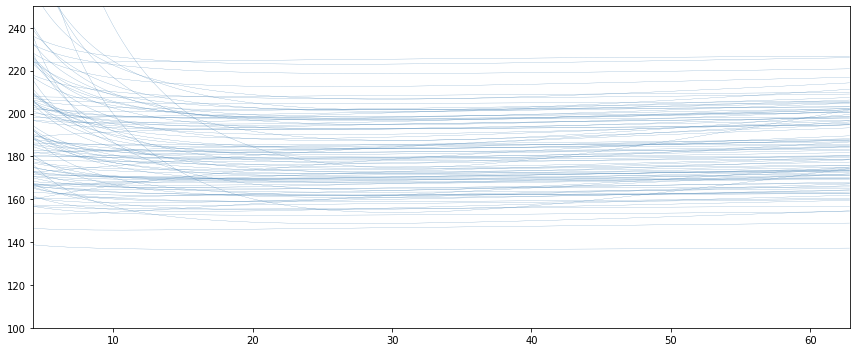

In [21]:
# Define grid over which we evaluate (prior) predictive distribution
min_p = d["weight_ln_s"].min()
max_p = d["weight_ln_s"].max()
x_grid = np.arange(min_p, max_p, 0.02)

# Svae grid also in original units for ease of comparison:
# first un-scale, then take exponent
x_grid_orig = np.exp(scaler_loglvl.inverse_transform(x_grid))

# Draw values for alpha and beta
alpha = np.random.normal(loc=178, scale=20, size=N)
beta1 = np.random.lognormal(mean=0, sigma=1, size=N)
beta2 = np.random.lognormal(mean=0, sigma=1, size=N)

# Calculate mu
mu = np.empty((len(x_grid),N))
for i,(a,b1,b2) in enumerate(zip(alpha, beta1, beta2)):
    mu[:,i] = a + b1*x_grid + b2*np.power(x_grid,2)
mu = pd.DataFrame(mu)

# Save index in original units
mu.index = x_grid_orig

# Plot prior predictive distribution for mu
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
_ = mu.plot(ax=ax, legend=False, color="steelblue", linewidth=0.2)
_ = ax.set_ylim(100,250)
plt.tight_layout()

### Fit model

In [22]:
%%R -i d,x_grid -o summary_mq2,sample_posterior_mq2,mu_mq2,mu_mean_mq2,mu_PI_mq2,height_PI_mq2

# Define model
flist = alist(
    height ~ dnorm(mu, sigma),
    mu <- a + b1 * weight_ln_s + b2 * weight_ln_s2,
    a ~ dnorm(178, 20),
    b1 ~ dlnorm(0,1),
    b2 ~ dlnorm(0,1),    
    sigma ~ dunif(0, 50)
)

# Build model for calculating draws from posterior
mq2 = quap(flist, data=d)

# Summary of analytical outcome
# Mean and std of marginal distribution of each parameter
summary_mq2 = precis(mq2)

# Draw samples of parameters from the (Gaussian approximated) posterior
# mus and sigmas
sample_posterior_mq2 = extract.samples(mq2, n=10000)

## Calculate mu posterior draws using function link
exo_grid = list(weight_ln_s=x_grid, weight_ln_s2=x_grid^2)

# Posterior distribution for mu
mu_mq2 = link(mq2, data=exo_grid)

# Mean mu
mu_mean_mq2 = apply(mu_mq2, 2, mean)

# To simulate observations that average over posterior distributions, use sim
sim_height_mq2 = sim(mq2, data=exo_grid)

# Probability intervals for mu and simualted heights
mu_PI_mq2 = apply(mu_mq2, 2, PI, prob=0.89)
height_PI_mq2 = apply(sim_height_mq2, 2, PI, prob=0.89)
#
# Output R objects in better format
mu_mq2 = as.data.frame(t(mu_mq2))
mu_PI_mq2 = as.data.frame(t(mu_PI_mq2))
height_PI_mq2 = as.data.frame(t(height_PI_mq2))

In [23]:
mu_mq2.index = x_grid_orig

### Plot results in original weight units

        mean   sd   5.5%  94.5%

a     138.19 0.23 137.83 138.55

b1     27.18 0.23  26.81  27.54

b2      0.07 0.05   0.00   0.15

sigma   5.15 0.16   4.90   5.40



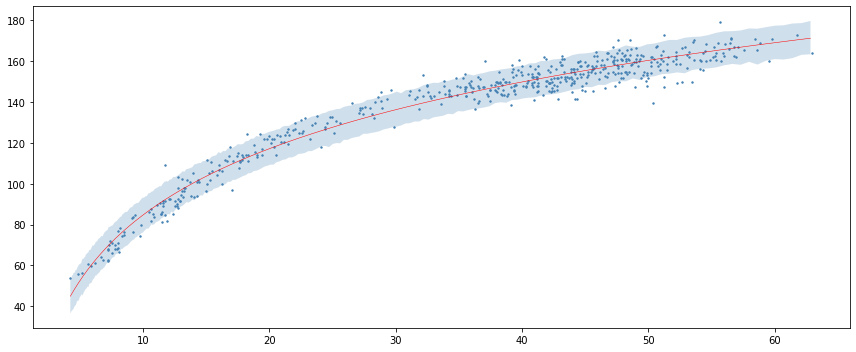

In [24]:
# Summary
print(summary_mq2)

# Plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
x = np.exp(scaler_loglvl.inverse_transform(x_grid))

_ = ax.scatter(x="weight", y="height", c="steelblue", s=2, data=d)
_ = ax.fill_between(x, height_PI_mq2.iloc[:,0], height_PI_mq2.iloc[:,1], facecolor='steelblue', alpha=0.25)
#_ = mu_mq2.iloc[:,:50].plot(ax=ax, legend=False, linewidth=0.5, alpha=0.2)
_ = ax.plot(x, mu_mean_mq2, c='red', linewidth=0.5)
#_ = ax.fill_between(x, mu_PI_mq2.iloc[:,0], mu_PI_mq2.iloc[:,1], facecolor='red', alpha=0.25)
plt.tight_layout()

## Question 3

*Plot the prior predictive distribution for the polynomial regression model in Chapter 4. You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of alpha, beta1, and beta2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.*

We basically answered this in Question 2.